# Continued EDA for Senior Thesis
Adding Geopatial Bounding

## Dependencies

In [1]:
# libraries that I may potential need:
import pandas as pd
import math
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.warp
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
import geopandas as gpd
from shapely.geometry import Point, box
from pandas.plotting import scatter_matrix
import random
import seaborn as sns

## Variables

### Used Google Translate to reencocde variable names:
| original variable name | translated variable name |
| --- |--- |
| gattung_botanisch  | botanical genus     |
| gattung_deutsch    | German genus        |
| art_botanisch      | botanical species   |
| art_deutsch        | German species      |
| alleebaum          | avenue tree         |
| hoehe              | height              |
| stammdurchmesser   | trunk diameter      |
| stammumfang        | trunk circumference |
| kronendurchmesser  | crown diameter      |
| baumpatenschaft    | tree sponsorship    |

In [2]:
# set path to data set
path_tree       = '../data/data_gov_de/trees/baeume.json'
path_parks      = '../data/data_gov_de/parks/parkanlagen.json'
path_cemeteries = '../data/data_gov_de/cemeteries/friedhoefe.json'

# create german to english variable name map
recoded_column_names = {
    'gattung_botanisch' : 'botanical_genus'     ,
    'gattung_deutsch'   : 'German_genus'        ,
    'art_botanisch'     : 'botanical_species'   ,
    'art_deutsch'       : 'German-species'      ,
    'alleebaum'         : 'avenue_tree'         ,
    'hoehe'             : 'height'              ,
    'stammdurchmesser'  : 'trunk_diameter'      ,
    'stammumfang'       : 'trunk_circumference' ,
    'kronendurchmesser' : 'crown_diameter'      ,
    'baumpatenschaft'   : 'tree_sponsorship'    ,
    'bezeichnung'   : 'designation'    ,
    }

# set standard deviation limit to constrain outliers
sd_limit = 3

# isolate cohorts for analysis that are not outliers and have less than n units min_count = 50
min_count = 50

# Gausian smoother coefficient
smother_sd = 1/2

## Functions

In [3]:
def CRS_printer(gpd:gpd.GeoDataFrame):
    """
    # Prints the current Cordiante Reference System (CRS) for a GeoPandas (gpd) Dataframe.
    ## Expects:
    - a gpd.DataFrame object
    """
    if hasattr(gpd, 'crs'):
        print(f"CRS Object: {gpd.crs}")
        return gpd.crs
    else:
        print("No explicit CRS found using geojson library.")

def list_printer(a_list:list, number_of_items_to_print:int = 10000, span:int=80):
    """
    # Formated list printer
    ## Expects: 
     - A list like object
     - number of items from list to print. Default 10000
     - max length of page in. Assumes terminal is using fixed width font. Default 80
    ## Returns: Prints a formated list.
    """
    counter = 1
    list_len = len(a_list)
    max_len = len(max(a_list, key=len)) + 2
    if span > max_len:
        cols = round(span / max_len )
    else: return f'span {span} must be greater than len of longest item in list {max_len} +2'
    for i in a_list:
        if counter > number_of_items_to_print:
            break
        elif counter % cols == 0:
            print(f'{i:^{max_len}}')
        else: 
            print(f'{i:^{max_len}}', end= ' | ')
        counter += 1

def round_to_nearest_n(x, base):
    """
    # Rounds a value to the nearest multiple of 'base'.
    """
    return base * round(x / base)

def series_limit(series:pd.Series, sd_limit:int= 1) -> pd.Series:
    """
    # Mask values in a pandas series greater or equal to a limit.
    Limit defined by the number of standard devations away from the series mean the value is.
    Assumes a guasian distribution.
    """
    sample_sd = series.std()
    sample_mean = series.mean()
    limit = sample_mean + (sample_sd*sd_limit)
    mask = series <= limit
    return mask 

## Load Tree Data

In [4]:
# read GeoJson data into a GeoPandas DF
tree_gdf = gpd.read_file(path_tree, encoding='utf-8')

## Clean Tree Data

### translate variable names

In [5]:
# map translated variable names
tree_gdf = tree_gdf.rename(columns=recoded_column_names)

### split variable

In [6]:
# Split common name and species variable and create two new features
# - botanical_species_formal_name
# - botanical_species_common_name
tree_gdf[['botanical_species_formal_name', 'botanical_species_common_name']] = tree_gdf['botanical_species'].str.split(' „', expand=True).fillna(pd.NA)
tree_gdf['botanical_species_common_name'] = tree_gdf['botanical_species_common_name'].str.replace('“', '')

# Create mask for botanical_species_formal_name containing the string 'species'
# - We are isolating units where a generalization from a species to a genus was made.
mask_botanical_species_formal_name = tree_gdf['botanical_species_formal_name'].str.contains('species')
# set masked recs to NA
tree_gdf.loc[mask_botanical_species_formal_name, 'botanical_species_formal_name'] = pd.NA

### list unique species

In [7]:
# aint-subset units whose species has been generalized to a genus to a list
species = tree_gdf['botanical_species_formal_name'][~mask_botanical_species_formal_name].unique().tolist()

### mask outliers

In [8]:
# we create a mask to subset by trees whose height within 
# `sd_limit` standard deviations of the mean height
# - Note: The tallest tree in Germany is about 68 meters.
# - Trees taller than that are excluded.
mask_height = series_limit(tree_gdf['height'],sd_limit)

# we create a mask to subset by trees whose trunk_diameter is within 
# `sd_limit` standard deviations of the mean trunk_diameter
mask_trunk_diameter = series_limit(tree_gdf['trunk_diameter'],sd_limit)

# we create a mask to subset by trees whose trunk_circumference is within 
# `sd_limit` standard deviations of the mean trunk_circumference
mask_trunk_circumference = series_limit(tree_gdf['trunk_circumference'], sd_limit)

# we create a mask to subset by trees whose crown_diameter is within 
# `sd_limit` standard deviations of the mean crown_diameter
mask_crown_diameter = series_limit(tree_gdf['crown_diameter'],sd_limit)

# generate a uniform mask that excludes outliers across all continuious variables
# - Note: We do not drop these units, as these are still trees 
#         and may contribute to a future competitive density feature.
mask_non_outlier = mask_height & mask_trunk_diameter & mask_trunk_circumference & mask_crown_diameter

# isolate cohorts for analysis sans-outliers, having >= n units 
# counts by species of non outliers.
non_outlier_cohort_counts = tree_gdf[mask_non_outlier].groupby('botanical_species_formal_name')\
    ['botanical_species_formal_name'].count()
# list of cohorts that meet minimum representation
valid_species = non_outlier_cohort_counts[non_outlier_cohort_counts > min_count].index.to_list()

# mark those records whoes species cohort meets minimum representation...
tree_gdf['qualified_species_representation'] = tree_gdf['botanical_species_formal_name'].isin(valid_species)
# ... and that do not contain outliers.
tree_gdf['in_qualified_cohort'] = tree_gdf['botanical_species_formal_name'].isin(valid_species) & mask_non_outlier

### correcting digit preference bias
Note: See EDA_20260209 for evidence of rounding bias.

In [9]:
# generate features with gausian smoother

# round height to nearest integer ...
tree_gdf['height_standardized'] = tree_gdf['height'].round()
# ...and apply smoother:
tree_gdf['height_standardized'] = tree_gdf['height_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd))

# round crown_diameter to nearest integer ...
tree_gdf['crown_diameter_standardized'] = tree_gdf['crown_diameter'].round()
# ...and apply smoother:
tree_gdf['crown_diameter_standardized'] = tree_gdf['crown_diameter_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd))

# round trunk_circumference to nearest 9th centimeter ...
tree_gdf['trunk_circumference_standardized'] = tree_gdf['trunk_circumference'][tree_gdf['trunk_circumference'].notna()].apply(lambda x: round_to_nearest_n(x, base=9))
# ...and apply smoother:
tree_gdf['trunk_circumference_standardized'] = tree_gdf['trunk_circumference_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd*9))

# round trunk_diameter to nearest 3rd centimeter ...
tree_gdf['trunk_diameter_standardized'] = tree_gdf['trunk_diameter'][tree_gdf['trunk_diameter'].notna()].apply(lambda x: round_to_nearest_n(x, base=3))
# ...and apply smoother:
tree_gdf['trunk_diameter_standardized'] = tree_gdf['trunk_diameter_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd*3))


## Generate abstraction features

In [10]:
# generate baseline abstraction feature: volume
tree_gdf['volume_m^2'] = tree_gdf['height_standardized'] * (math.pi*((tree_gdf['crown_diameter_standardized']/2)**2))
# generate baseline abstraction feature: cover_area
tree_gdf['cover_area_m^2'] = (math.pi*((tree_gdf['crown_diameter_standardized']/2)**2))

## Review

In [11]:
tree_gdf.sample(5)

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,...,botanical_species_formal_name,botanical_species_common_name,qualified_species_representation,in_qualified_cohort,height_standardized,crown_diameter_standardized,trunk_circumference_standardized,trunk_diameter_standardized,volume_m^2,cover_area_m^2
20437,855f0d14-39bb-4458-854e-077330bbe099,Ulmus,Ulme,Ulmus species,Ulme,False,13.0,22.00,69.12,8.0,...,<NA>,<NA>,False,False,12.872148,7.767646,66.570052,20.932191,609.985852,47.388037
55424,cc5b8f52-2654-46b1-bad1-1091a1a54759,Prunus,Kirsche,Prunus avium „Große Schwarze Knorpelkirsche“,Kirsche „Große Schwarze Knorpelkirsche“,False,NaN,NaN,NaN,NaN,...,Prunus avium,Große Schwarze Knorpelkirsche,True,False,NaN,NaN,NaN,NaN,NaN,NaN
70225,e976012a-b501-4bff-8dd3-bc37767cb331,Tilia,Linde,Tilia platyphyllos,Sommer-Linde,True,22.0,76.39,240.00,15.0,...,Tilia platyphyllos,<NA>,True,True,22.777461,15.232967,243.069828,71.416812,4151.109392,182.246362
46364,3e423b64-f699-412b-99af-10882c20986d,Gleditsia,Lederhülsenbaum,Gleditsia triacanthos,Amerikanische Gleditschie,True,10.0,38.20,120.00,5.0,...,Gleditsia triacanthos,<NA>,True,True,10.941388,4.429635,110.945053,42.123979,168.615774,15.410821
49858,c8515860-21f1-47c5-a15e-5b585453870f,Robinia,Scheinakazie,Robinia pseudoacacia,Gemeine Robinie,False,22.0,40.11,126.00,10.0,...,Robinia pseudoacacia,<NA>,True,True,22.188289,9.908024,125.336618,37.766858,1710.754794,77.101699


Sample size = 139:


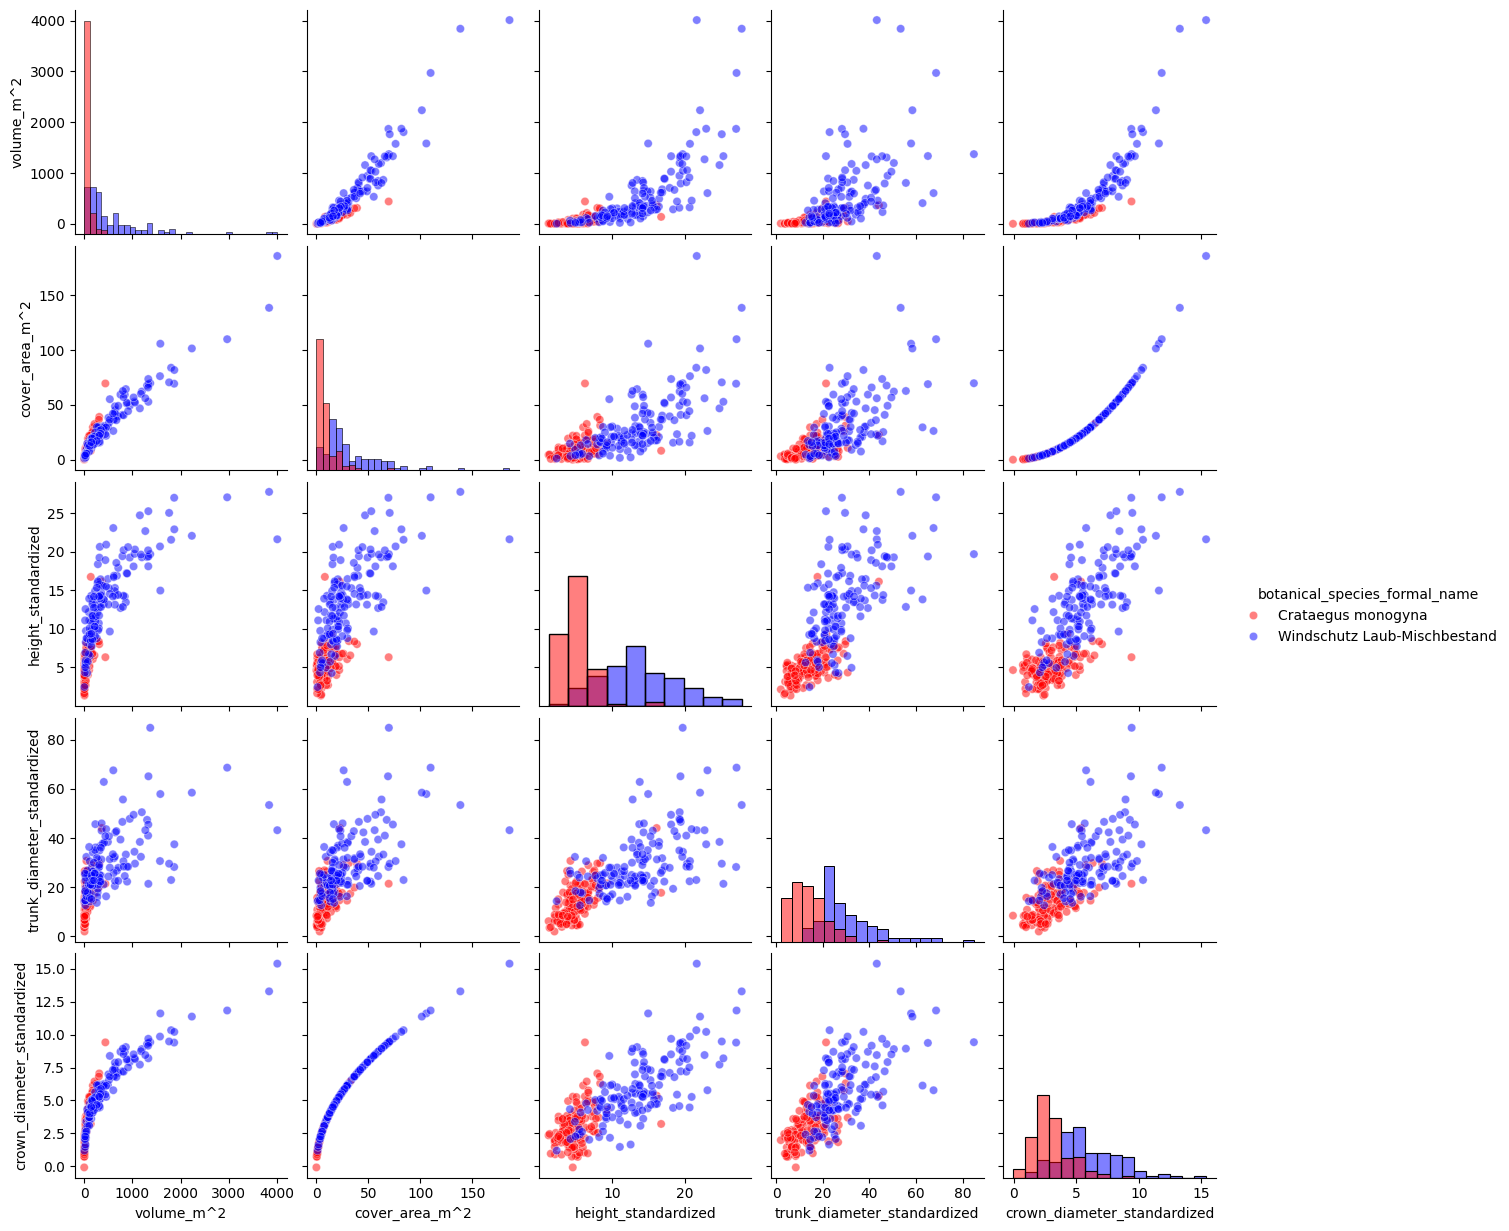

In [12]:
# matrix by species - comparison

## randomly select two valid species
rand_species_A = random.choice(valid_species)
rand_species_B = random.choice(valid_species)

# subset by species A
subset_A_with_labels = tree_gdf.loc[(tree_gdf['botanical_species_formal_name'] == rand_species_A) & 
                             (tree_gdf['in_qualified_cohort']), 
                             ['botanical_species_formal_name', 'volume_m^2','cover_area_m^2','height_standardized', 
                              'trunk_diameter_standardized','crown_diameter_standardized']]

# subset by species B
subset_B_with_labels = tree_gdf.loc[(tree_gdf['botanical_species_formal_name'] == rand_species_B) & 
                             (tree_gdf['in_qualified_cohort']), 
                             ['botanical_species_formal_name', 'volume_m^2','cover_area_m^2','height_standardized', 
                              'trunk_diameter_standardized','crown_diameter_standardized']]

# sample from each species 70% of the size of the smallest population
sizeA = subset_A_with_labels.shape[0]
sizeB = subset_B_with_labels.shape[0]
size = [sizeA if sizeA <= sizeB else sizeB]
size = round(size[0]*.7)
print(f'Sample size = {size}:')

# join subsets (Interesting that there is no gpd.concat. gpd relies on pd.conccat)
subset_with_labels = pd.concat([subset_A_with_labels.sample(size),subset_B_with_labels.sample(size)])

# pairplot
sns.pairplot(subset_with_labels, 
             hue='botanical_species_formal_name', 
             palette={rand_species_A: 'red', rand_species_B: 'blue'},
             diag_kind='hist', # Can also use 'kde' for smooth curves
             plot_kws={'alpha': 0.5})


# EDA - Round 2

### Remember:
Copernicus 10m pixel desity measurment is the response varaible

### Consideration → Convert to Copernicus CRS first?
Copernicus uses EPSG:3035

### General Defintions and rules
- Rule: Competition is constrained by polygon membership

- Define radius (r) for competition and diveristy
  - Notes on Neighborhood Competition Indices" (NCI) 
    - esajournals.onlinelibrary.wiley.com/doi/10.1002/ecs2.1273
    - It appears that influence tapers beyond 10 meters
  - Max crown_diameter in dataset is 21.95891198439781.
  - So, we could pull
    -  20 meters from trunk (Uniform)
    -  or 10 meters from edge of radius (Dynamic Crown-scaled radius)
  Note: 
    - We do not break sampling frame.  
    - Trees across polygon boundaries, but within a radius are not considered.

- Define Polygon edge buffer
  - (We are modeling the public forest network)

- Polygon buffer for inclusion in study
  - Buffer outside the edge risks inclusion unobserved trees.
  - Need to be able to adjust this dynamically
  - Or...  Make a choice on a park by park basis after manual review?

### For each tree:
- Define whether it is in a:
  - cemetery polygon
  - parks polygon
- Mark the apporpreate (bezeichnung) for each.
- Mark it's euclidian distance to the edge of the polygon
- Define denisty
  - n_neighbors: (count excluding self)
  - crown_area_sum proxy: sum of crown_diameter^2
- Define diversity
  - species_richness: number of unique species
  - shannon_index: robust diversity index

### For each municipal polygon
- Polygon-level density
- Tree-level local density
- Cross-scale competition
- Area (m^2)
- Perimiter (m^2)

### Validate
- Export inclusive trees as *.klm files and review in Google Earth on a per park basis


## Load public bounding boxes

In [13]:
# load parks polygons
parks_gdf = gpd.read_file(path_parks, encoding='utf-8')
# load cemeteries polygons
cem_gdf = gpd.read_file(path_cemeteries, encoding='utf-8')

In [25]:
# Check cordiante reference system (CRS) for all loaded GeoJsons matches
CRS_printer(tree_gdf)
CRS_printer(parks_gdf)
CRS_printer(cem_gdf)
print()

CRS Object: EPSG:3035
CRS Object: EPSG:3035
CRS Object: EPSG:3035



In [15]:
# convert CRS from `EPSG:4326` to `EPSG:3035` to align with copernicus data
tree_gdf.to_crs(epsg=3035, inplace=True)
parks_gdf.to_crs(epsg=3035, inplace=True)
cem_gdf.to_crs(epsg=3035, inplace=True)

In [16]:
# map translated variable names
cem_gdf = cem_gdf.rename(columns=recoded_column_names)
parks_gdf = parks_gdf.rename(columns=recoded_column_names)

In [17]:
# build features

# type
cem_gdf['type'] = 'cemetery'
parks_gdf['type'] = 'park'

# perimeter
cem_gdf['perimeter_m'] = cem_gdf['geometry'].length
parks_gdf['perimeter_m'] = parks_gdf['geometry'].length

# area
cem_gdf['area_m^2'] = cem_gdf['geometry'].area
parks_gdf['area_m^2'] = parks_gdf['geometry'].area


In [18]:
# concatnate parks and cemetery polygons
pc_gdf = pd.concat([cem_gdf,parks_gdf])

In [ ]:
# spaitial leftouter-join trees to parks and cemeteries
# Note: Keeping all trees in origional dataset for now.
enriched_tree_gdf = gpd.sjoin(left_df= tree_gdf,
                              right_df= pc_gdf[['designation','type','geometry']],
                              how='left', 
                              predicate='intersects'
                              ).drop(columns=['index_right'])

In [20]:
# For each tree within a polygon, find distance to nearest polygon edge

# subset the enriched_tree dataframe down to those records that are within polygons.
# Note: use of .copy()
subset_gdf = enriched_tree_gdf[enriched_tree_gdf['type'].notna()].copy()

# Convert the polygons in pc_gdf to edges only:
pc_boundaries = pc_gdf.copy()
pc_boundaries.geometry = pc_gdf.geometry.boundary

# Spatial leftjoin-nearest subset to polygonss and record distance to nearest edge (up to 500 meters away)
subset_gdf = gpd.sjoin_nearest(left_df=subset_gdf,
                               right_df= pc_boundaries,
                               how= 'left',
                               distance_col= 'dist_to_edge')


# # join the subset_gdf back to enriched_tree_gdf.
enriched_tree_gdf = enriched_tree_gdf.join(subset_gdf[['dist_to_edge']], how='left')

# delete temp dataframes
del (pc_boundaries)
del (subset_gdf)

In [26]:
enriched_tree_gdf[enriched_tree_gdf['type'].notna()].sample(5)

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,...,in_qualified_cohort,height_standardized,crown_diameter_standardized,trunk_circumference_standardized,trunk_diameter_standardized,volume_m^2,cover_area_m^2,designation,type,dist_to_edge
4615,828c9f64-d1f4-46fc-8cb6-6f3678915b5e,Acer,Ahorn,Acer species,Ahorn,False,21.0,26.74,84.00,7.0,...,False,21.686683,6.040518,73.813892,25.555230,621.486128,28.657501,Lindenpark,park,184.953550
26087,899323ea-e63a-4634-9f56-15b46ebf721a,Fagus,Buche,Fagus sylvatica,Rotbuche,False,23.0,21.33,67.00,8.0,...,True,22.634289,8.035191,57.926902,16.734273,1147.754991,50.708683,Barnstorfer Anlagen,park,930.379173
49977,3b0ab894-a7ca-4ec7-83da-514a3cbd35e8,Pseudotsuga,Douglasie,Pseudotsuga menziesii,Gewöhnliche Douglasie,False,11.0,23.55,74.00,4.0,...,True,11.049793,4.540234,71.259968,23.643576,178.895926,16.189980,Barnstorfer Anlagen,park,716.779508
60513,49076e1d-03c2-4b19-a472-4652c7280503,Tilia,Linde,Tilia species,Linde,True,31.0,76.00,238.76,8.0,...,False,31.793903,7.181551,244.389640,75.283236,1287.864557,40.506652,Lindenpark,park,123.698812
64146,c1a11245-281d-4589-a5bb-d837d0d179bb,Acer,Ahorn,Acer platanoides,Spitz-Ahorn,False,14.0,18.78,59.00,4.0,...,True,13.572020,4.081704,51.383016,18.643607,177.589584,13.084978,Arankapark,park,2.028302
